In [206]:
!dir

 驱动器 C 中的卷是 Windows
 卷的序列号是 A035-214C

 C:\Users\XIAOWEI\OneDrive\附件\实验室事务\科研\报告20200330\code 的目录

2020/03/30  11:32    <DIR>          .
2020/03/30  11:32    <DIR>          ..
2020/03/30  09:32    <DIR>          .ipynb_checkpoints
2020/03/30  11:32         1,816,892 RBFNN.ipynb
2020/03/22  22:56            10,115 RBFNN.py
2020/02/18  08:48            27,517 RLS.ipynb
2020/03/30  10:00            11,324 rossler.pdf
               4 个文件      1,865,848 字节
               3 个目录 11,109,625,856 可用字节


In [207]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from math import *
from scipy.cluster.vq import kmeans2

names = ['rossler', 'rabinovich_fabrikant', 'lorentz', 'chen', 'chua', 'switch']
system_name = names[0]

In [215]:
class RBFNN:
    def __init__(self, N_h, skip_con=True, bias=True, reweight=True):
        
        self.skip_con=skip_con
        self.bias = bias
        self.reweight = reweight
        self.N_i = None
        self.N_o = None
        self.N_h = N_h
        self.N_f = N_h
        self.sigma = 1
        self.beta = 1e-6
    
    @staticmethod
    def pairwise_distances(X, Y):
        D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
        D[D < 0] = 0
        return D
    
    @staticmethod
    def pairwise_dtw_distances(X,Y):
        m, n = X.shape[0], Y.shape[0]
        D = np.empty((m, n))
        for i in range(m):
            for j in range(n):
                D[i,j] = DTWDistance(X[i],Y[j])
        return D
                
    @staticmethod
    def DTWDistance(s1, s2, w=2):
        DTW={}

        w = max(w, abs(len(s1)-len(s2)))

        for i in range(-1,len(s1)):
            for j in range(-1,len(s2)):
                DTW[(i, j)] = float('inf')
        DTW[(-1, -1)] = 0

        for i in range(len(s1)):
            for j in range(max(0, i-w), min(len(s2), i+w)):
                dist= (s1[i]-s2[j])**2
                DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

        return np.sqrt(DTW[len(s1)-1, len(s2)-1])


    @staticmethod
    def col_softmax(x):
        x_col_max = x.max(axis=0)
        x_col_max = x_col_max.reshape([1,x.shape[1]])
        x = x - x_col_max
        x_exp = np.exp(x)
        x_exp_col_sum = x_exp.sum(axis=0).reshape([1,x.shape[1]])
        softmax = x_exp / x_exp_col_sum
        return softmax
    
    @staticmethod
    def col_normalize(x):
        x_sum = x.sum(axis=0).reshape([1,x.shape[1]])
        softmax = x / x_sum
        return softmax
    
    def _pre_output(self, X):
        
        threshold = 1
        
#         X -= np.min(X,axis=0)

        # 隐层输出
        H = np.exp(-self.pairwise_distances(self.W_i, X.T)/threshold)
        
        if self.skip_con:
            H = np.vstack([H,X])
            self.N_f += self.N_i
        
        ones = np.ones((1,H.shape[1]))

        if self.bias:
            H = np.vstack([H,ones])
            self.N_f += 1
        
        if self.reweight:
            linear_weight  = 1
            pre_weight = self.col_softmax(np.vstack([H[:self.N_h],linear_weight * ones]))
            H[:self.N_h] = pre_weight[:-1]
            H[self.N_h:] *= pre_weight[-1:]
        
        return H


        
    def train(self, X, Y):
        self.N_i = X.shape[0]
        self.N_o = Y.shape[0]
        
#         self.W_i = np.random.uniform(-self.sigma,self.sigma, (self.N_h, self.N_i))
#         self.W_i = X.T[np.random.choice(X.shape[1],self.N_h,replace=False)]
        if self.N_h <= 0:
            self.W_i = np.empty((0,self.N_i))
        else:
            self.W_i, _ = kmeans2(X.T, self.N_h, minit='points')
        
        H = self._pre_output(X)
        
        self.W_o = Y.dot(H.T.dot(np.linalg.inv(H.dot(H.T)+self.beta*np.eye(self.N_f))))
     
    def predict(self, X):
        H = self._pre_output(X)  
        return self.W_o.dot(H)
    
    def predict_mutistep(self, X, horizon):
        Y = np.empty((self.N_o *horizon, X.shape[1]))
        Z = np.vstack([X,Y])
        start = X.shape[0]
        Z[start:start+self.N_o,:] = self.predict(X)
        for i in range(1,horizon):
            Z[start+i*self.N_o : start+(i+1)*self.N_o, :] = self.predict(Z[i*self.N_o : start+i*self.N_o,:])
        return Z[start:,:]
            

In [216]:
def dxdt(F, X, t, h=1e-2):
    assert(len(F)==len(X))
    X = np.array(X)
    K1 = np.array([f(X, t) for f in F])
    dX = h*K1/2
    K2 = np.array([f(X+dX, t+h/2) for f in F]) 
    dX = h*K2/2
    K3 = np.array([f(X+dX, t+h/2) for f in F])
    dX = h*K3 
    K4 = np.array([f(X+dX, t+h) for f in F])

    dX = (K1 + 2*K2 + 2*K3 + K4)*h/6

    return dX

def trajectory(F, initial_point, num_points=1e4, h=1e-2):
    assert(len(F)==len(initial_point))
    
    n = int(num_points)
    dim = len(initial_point)
    X = np.zeros([n,dim])
    
    X[0,:] = initial_point
    for k in range(1,n):
        dX = dxdt(F,X[k-1,:],h*(k-1),h)
        X[k,:] = X[k-1,:] + dX
        
    return X.T

def gen_model(name:str):

    chaotic_systems = dict(
        rossler = Rossler,
        rabinovich_fabrikant = RabinovichFabrikant,
        lorentz = Lorentz,
        chen = Chen,
        chua = Chua,
        switch = Switch
    )

    if name not in chaotic_systems:
        raise Exception("Invalid system model: {}. Must be one of {}".
            format(name, list(chaotic_systems.keys())))
        
    return chaotic_systems[name]()

def Rossler():
    
    A = 0.25
    B = 1
    C = 5
    x0, y0, z0 = -2.0,  2.0,  0.2
    
    def f1(X, t):
        x,y,z = X[0],X[1],X[2]
        return -y-z

    def f2(X, t):
        x,y,z = X[0],X[1],X[2]
        return x + A*y

    def f3(X, t):
        x,y,z = X[0],X[1],X[2]
        return B + z*(x - C)
    
    return [f1, f2, f3], [x0, y0, z0], 2e-1

def Switch():
    '''
    5 vortex
    '''
    def g(x):
        return np.sum([np.sign(x+2*k-1)+np.sign(x-2*k+1) for k in range(1,3)])/2

    a = -4
    b = 0.2
    c = -5
    x0, y0, z0 = 0.1, 0.1, 0.1

    def f1(X, t):
        x,y,z = X[0],X[1],X[2]
        return a*y

    def f2(X, t):
        x,y,z = X[0],X[1],X[2]
        return x-g(x+z)+b*y

    def f3(X, t):
        x,y,z = X[0],X[1],X[2]
        return c*(z-g(x+z))
    
    return [f1, f2, f3], [x0, y0, z0], 1e-1

def RabinovichFabrikant():
    ParamA = 1.1
    ParamB = 0.87
    x0, y0, z0 = -1, 0, 0.5

    def f1(X, t):
        x,y,z = X[0],X[1],X[2]
        return y*(z - 1 + x*x) + ParamB*x

    def f2(X, t):
        x,y,z = X[0],X[1],X[2]
        return x*(3*z + 1 - x*x) + ParamB*y

    def f3(X, t):
        x,y,z = X[0],X[1],X[2]
        return -2*z*(ParamA + x*y)
    
    return [f1, f2, f3], [x0, y0, z0], 1e-1


def Chua():
    '''
    3 vortex chua
    '''
    def g(x):
        return 0.6*x -1.1*x*fabs(x) + 0.45*x**3

    a = 12.8
    b = 19.1
    x0, y0, z0 = 1.7, 0.0, -1.9

    def f1(X, t):
        x,y,z = X[0],X[1],X[2]
        return a*(y -g(x))

    def f2(X, t):
        x,y,z = X[0],X[1],X[2]
        return x - y + z

    def f3(X, t):
        x,y,z = X[0],X[1],X[2]
        return -b*y
    
    return [f1, f2, f3], [x0, y0, z0], 5e-2


def Lorentz():
    '''
    2 vortex lorentz
    '''
    C = 8/3
    B = 28
    A = 10
    
    x0, y0, z0 = -2.0, -3.7, 20.1
    
    def f1(X, t):
        x,y,z = X[0],X[1],X[2]
        return A*(y - x)


    def f2(X, t):
        x,y,z = X[0],X[1],X[2]
        return B*x - y - x*z


    def f3(X, t):
        x,y,z = X[0],X[1],X[2]
        return x*y - C*z

    return [f1, f2, f3], [x0, y0, z0], 2e-2


def Chen():
    a=40.
    b=3.
    c=28.
    x0=-0.1
    y0=0.5
    z0=-0.6
    
    x0, y0, z0 = 8.4, 7.7, 18.5


    def f1(X, t):
        x,y,z = X[0],X[1],X[2]
        return a*(y - x)

    def f2(X, t):
        x,y,z = X[0],X[1],X[2]
        return (c-a)*x - x*z + c*y

    def f3(X, t):
        x,y,z = X[0],X[1],X[2]
        return x*y - b*z
    
    return [f1, f2, f3], [x0, y0, z0], 2e-2


def rescale(x):
    row_max = np.max(x,axis=1).reshape((x.shape[0],1))
    row_min = np.min(x, axis=1).reshape((x.shape[0],1))
    return (x - row_min)/(row_max-row_min)

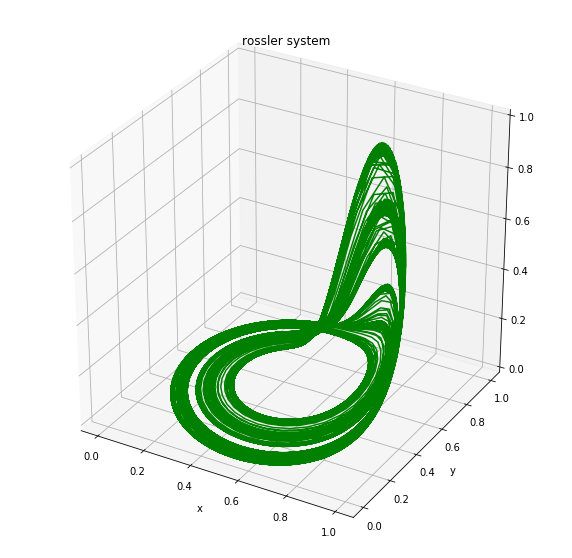

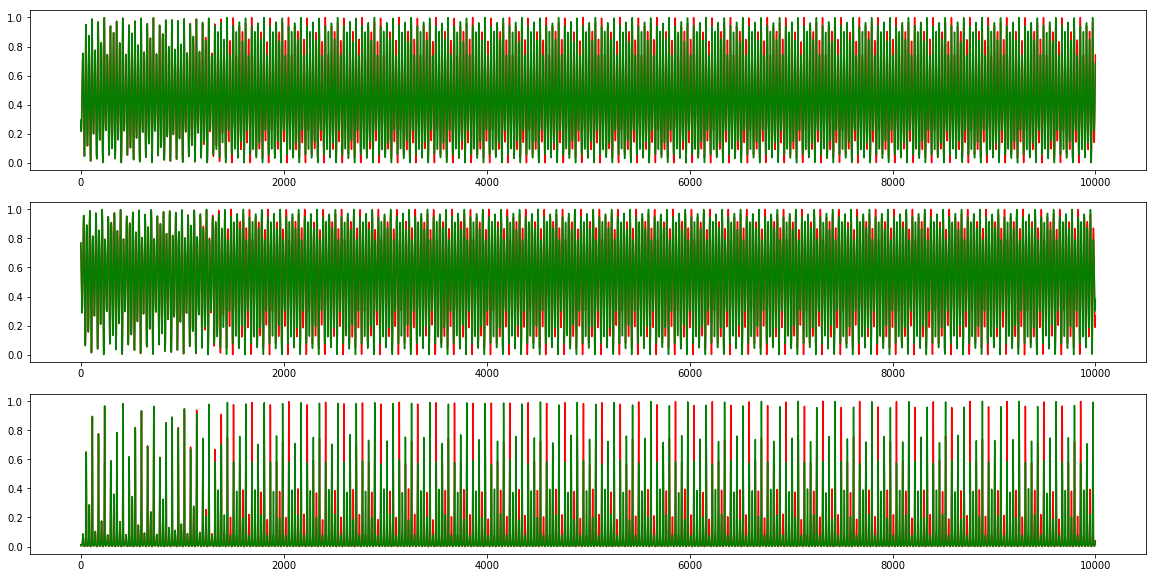

In [217]:
functions, start_point, step = gen_model(system_name)
N = 10000

x = trajectory(functions, start_point, N, step)
pertubed = [i + np.random.randn()*0.01 for i in start_point]
x_ = trajectory(functions, pertubed, N, step)
x, x_ = rescale(x), rescale(x_)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.plot(*x, 'g')
plt.xlabel('x')
plt.ylabel('y')
plt.title(system_name+' system')
plt.savefig('../figures/'+system_name+'_system.pdf')

plt.show()
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(x[0], 'r'), plt.plot(x_[0], 'g')
plt.subplot(3,1,2)
plt.plot(x[1], 'r'), plt.plot(x_[1], 'g')
plt.subplot(3,1,3)
plt.plot(x[2], 'r'), plt.plot(x_[2], 'g')
plt.show()

(30, 5000) (3, 5000)
(30, 2000) (3, 2000)


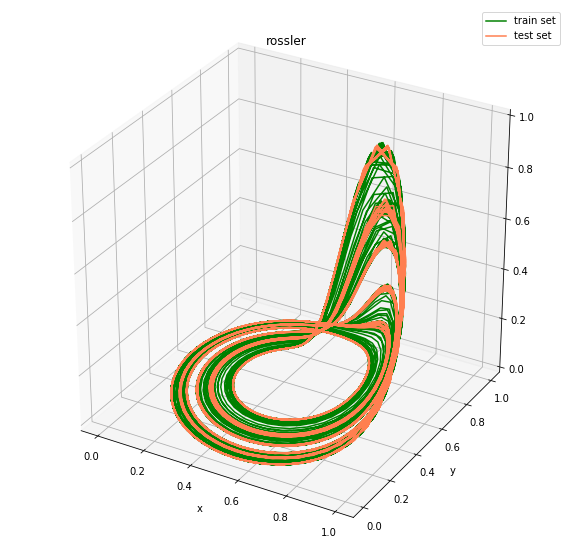

Text(0.5, 0, 't')

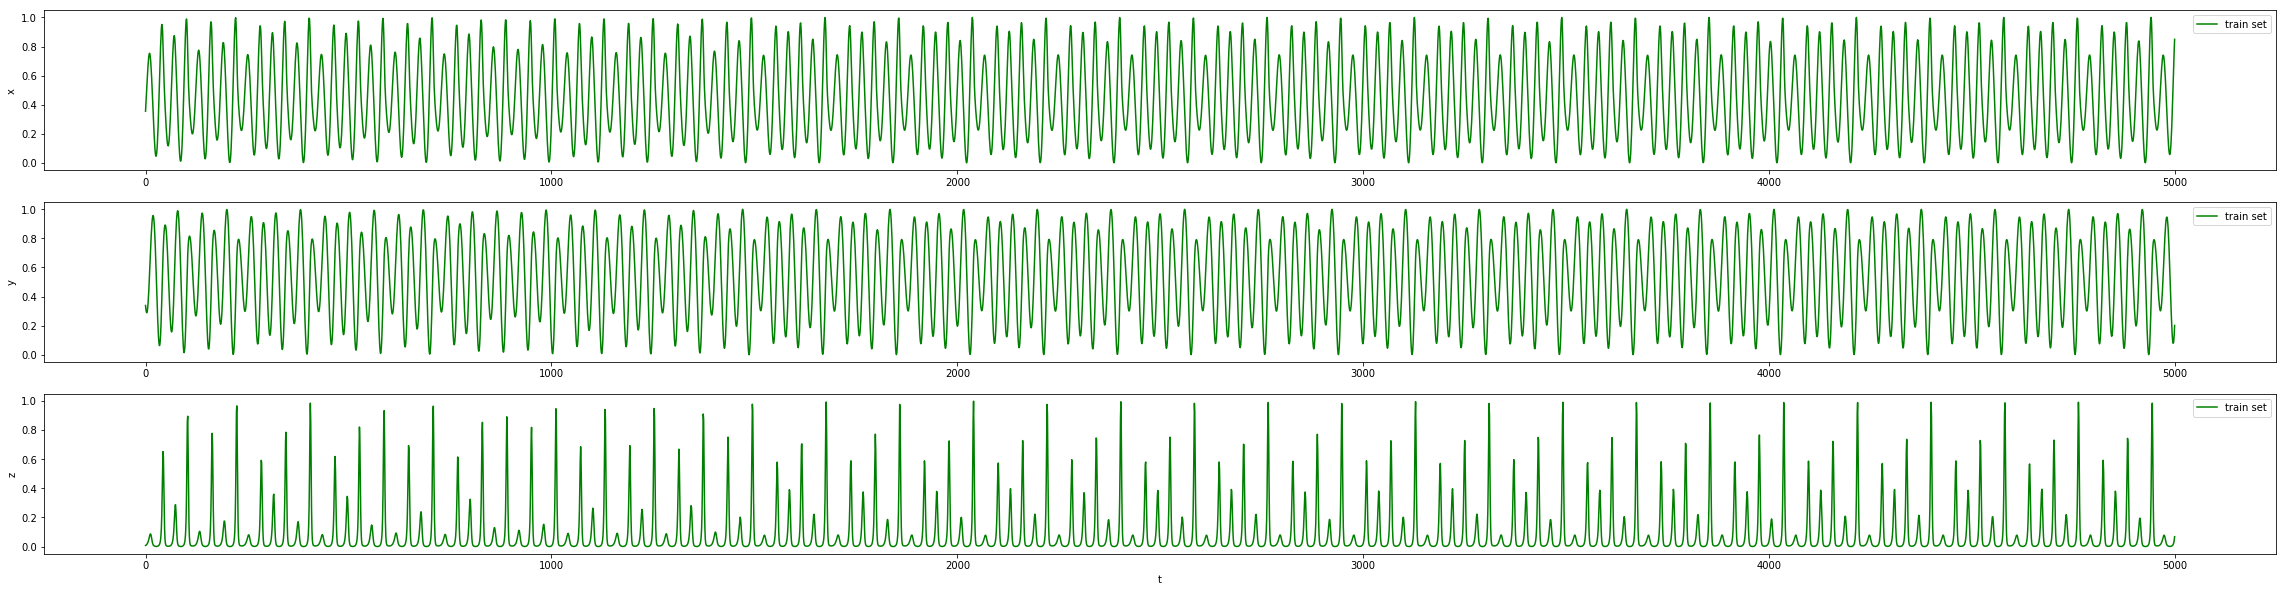

In [218]:
def select_samples(X, start, num):
    return X[:,start:start+num]


n = 10  # 使用 n 个历史点作为输入

num_train = 5000
train_start = 0
x_train = np.vstack([select_samples(x, train_start+i, num_train) for i in range(n)])
y_train = select_samples(x, train_start+n, num_train)

num_test = 2000
test_start = 6000
x_test = np.vstack([select_samples(x, test_start+i, num_test) for i in range(n)]) # test set
y_test = select_samples(x, test_start+n, num_test)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.plot(*x_train[:3,:],'green',label='train set')
plt.plot(*y_test, 'coral',label = 'test set')
# plt.plot(*model.W_i[:,:3].T, 'ko',label='hidden layer')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title(system_name)
plt.savefig('../figures/'+system_name+'_split.pdf')
plt.show()

plt.figure(figsize=(40,10))
dim = ['x','y','z']
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(y_train[i,:].T, color='green',label='train set')
    plt.ylabel(dim[i])
    plt.legend(loc='upper right')
plt.xlabel('t')

Text(0.5, 0, 't')

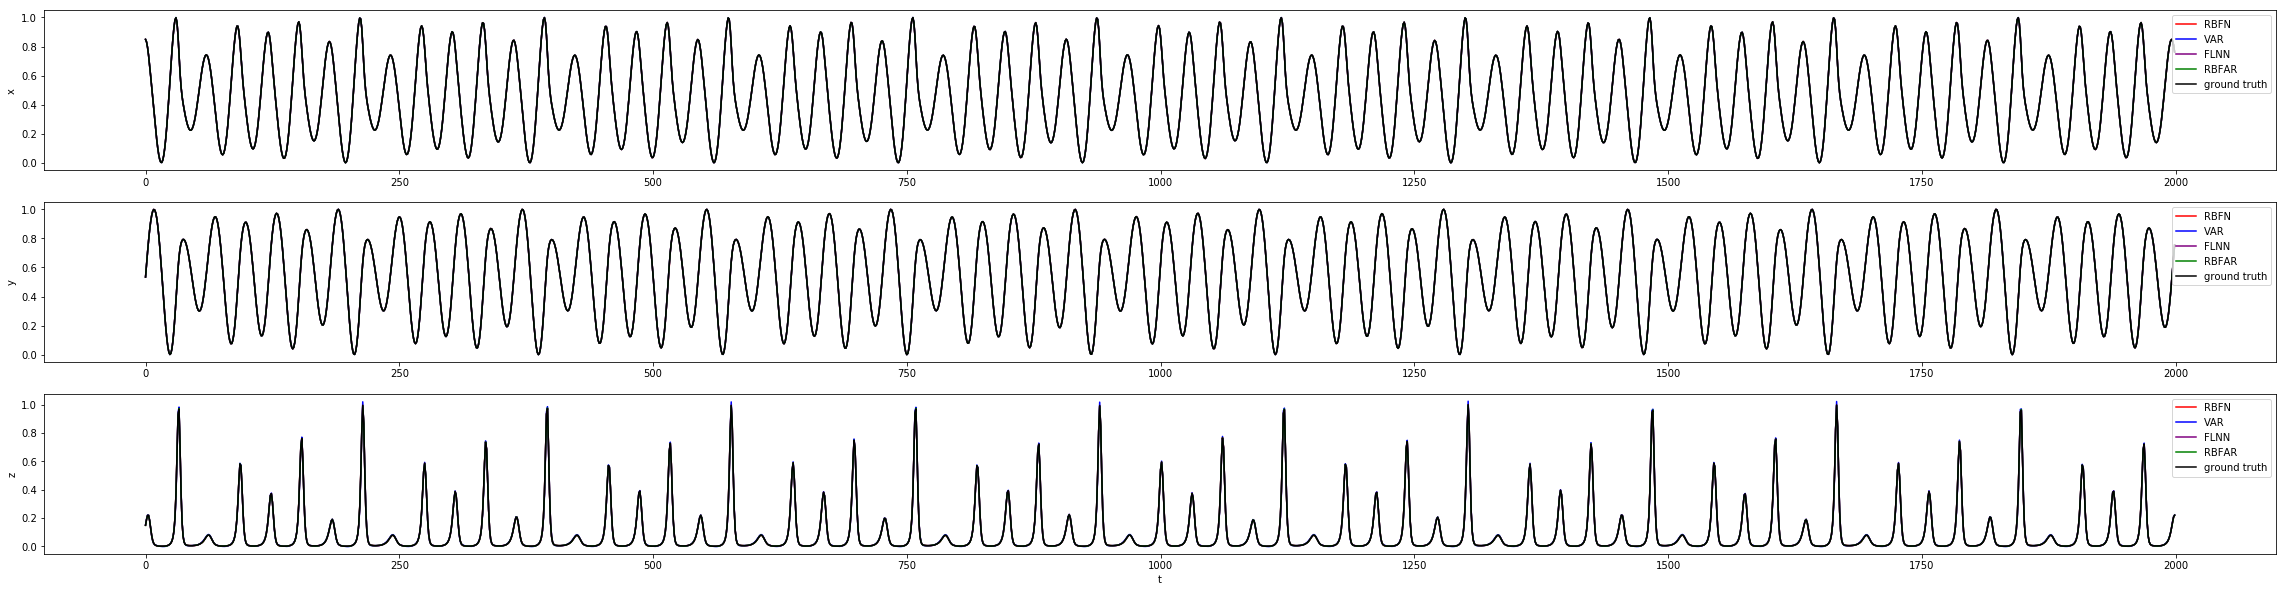

In [219]:
np.random.seed(42)
Predictions = [np.empty((3,num_test)) for _ in range(4)]
use_pred = False

model_confs = [('RBFN',100,0,0),('VAR',0,1,0),('FLNN',100,1,0),('RBFAR',100,1,1)]

for j,conf in enumerate(model_confs):
    model_name, n_neuron, skip_con, reweight = conf
    
    model = RBFNN(n_neuron,
                  skip_con=skip_con, 
                  reweight=reweight
                 )
    
    model.train(x_train, y_train)
    p = x_test[:,:1]
    for i in range(num_test):
        p_next = model.predict(p)
        Predictions[j][:,i] = np.squeeze(p_next)
        if use_pred:
            p = np.vstack([p,p_next])[3:]
        else:
            p = x_test[:,i+1:i+2]
    
    # draw something
#     fig = plt.figure(figsize=(20,15))
#     ax = fig.add_subplot(111, projection='3d')
#     plt.plot(*x_train[:3,:],'green',label='train set')
#     plt.plot(*model.W_i[:,:3].T, 'ko',label='hidden layer')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.title(model_name)
#     plt.legend()
#     plt.show()


model_names = ['RBFN','VAR','FLNN','RBFAR']
colors = ['red','blue', 'purple','green']

plt.figure(figsize=(40,10))
plt.title(system_name)
dim = ['x','y','z']
for i in range(3):
    plt.subplot(3,1,i+1)
    for j in range(4):
        plt.plot(Predictions[j][i,:].T,color=colors[j],label=model_names[j])
    plt.plot(y_test[i,:].T, color='black',label='ground truth')
    plt.ylabel(dim[i])
    plt.legend(loc='upper right')
plt.xlabel('t')

<Figure size 432x288 with 0 Axes>

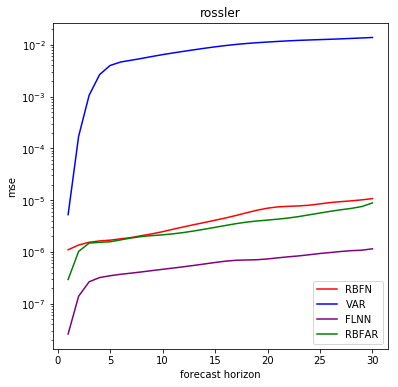

In [220]:
def rmse(A, B):
    return np.sqrt(np.sum(np.square(A-B)))

def mse(A, B):
    return np.mean(np.square(A-B))

def smape(A,B):
    A_norm1 = np.sum(np.abs(A))
    B_norm1 = np.sum(np.abs(B))
    return 2*np.sum(np.abs(A-B))/(A_norm1+B_norm1)

def mape(A,B):
    A_norm1 = np.abs(A)
    B_norm1 = np.abs(B)
    return np.sum(np.abs(A-B)/B_norm1)

def error_multistep(err_func,A, B):
    """
    A, B: np.array with shape (dim * horizon, 1)
    """
    assert(A.shape == B.shape)
    dim = 3
    horizon = A.shape[0]//dim
    mse_at_each_horizon = []
    for i in range(horizon):
        mse_at_each_horizon.append(err_func(A[i*dim:(i+1)*dim], B[i*dim:(i+1)*dim]))
    return mse_at_each_horizon


horizon = 30
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
for conf,color in zip(model_confs,colors):
    model_name, n_neuron, skip_con, reweight = conf
    
    model = RBFNN(n_neuron,
                  skip_con=skip_con, 
                  reweight=reweight
                 )
    
    model.train(x_train, y_train)
     
    Y_mutistep = model.predict_mutistep(x_test,horizon)
    Y_true = np.vstack([select_samples(x, test_start+n+i, num_test) for i in range(horizon)])

    mean_list = []
    for i in range(num_test):
        A = Y_mutistep[:,i:i+1]
        B = Y_true[:,i:i+1]
        err_list = error_multistep(mse, A,B)
        mean_list.append(err_list)

    mean_list = np.average(mean_list,axis=0)
    plt.plot([i+1 for i in range(horizon)],mean_list, label=model_name, color=color)
    plt.ylabel('mse')
    plt.xlabel('forecast horizon')
#     plt.grid(True)
#     plt.xticks([i*5 for i in range(1,7)])
#     plt.ylim([0,0.005])
ax.set_yscale("log")
plt.legend(loc='lower right')
plt.title(system_name)
plt.savefig('../figures/'+system_name+'.pdf')

In [214]:
# model_names = ['RBFN','VAR','FLNN','RBFAR']
# model_name, n_neuron, skip_con, reweight = model_confs[3]
    
# model = RBFNN(n_neuron,
#               skip_con=skip_con, 
#               reweight=reweight
#              )

# model.train(x_train, y_train)
# Y_mutistep = model.predict_mutistep(x_test,horizon)
# Y_true = np.vstack([select_samples(x, test_start+n+i, num_test) for i in range(horizon)])

# for i in [50,200,500,1000]:
#     A = Y_mutistep[:,i:i+1]
#     B = Y_true[:,i:i+1]
#     plt.figure()
#     for j in range(3):
#         plt.subplot(3,1,j+1)
#         plt.plot(A[j::3], label='predict')
#         plt.plot(B[j::3], label='true')
#         plt.legend(loc='upper right')

In [228]:
x_test[:3,0]

array([0.31629673, 0.2585552 , 0.0055744 ])